# Phishing vs Legitimate URL Classifier (2-Class)

**Project Overview:**

Phishing remains one of the most prevalent and dangerous cybersecurity threats, exploiting human trust to steal sensitive information such as passwords, credit card numbers, and authentication tokens. To combat this threat, security operations teams (SOCs) rely heavily on automated tools to classify URLs and detect malicious activity in real-time.

This project presents a lightweight yet explainable machine learning-based solution for classifying URLs as either legitimate or phishing. It is tailored not just for academic or proof-of-concept purposes, but also for integration into SOC workflows, enabling real-time URL classification, logging, risk assessment, and response recommendations — all from a single interactive interface.

The model uses character-level TF-IDF vectorization and a logistic regression-based classifier trained on labeled URL data. It is intentionally designed without the use of complex deep learning models to ensure transparency, explainability, and ease of deployment in resource-constrained environments.

One of the standout features of this tool is its ability to provide real-time explainability without using SHAP or LIME, which are often resource-heavy and harder to interpret in SOC pipelines. Instead, it derives the top contributing features directly from the model’s coefficients, providing human-readable indicators to help analysts understand the reasoning behind each classification.

Additionally, this tool mimics SOC-style detection and response workflows by:

Logging prediction data with timestamps

Assigning risk scores based on model confidence

Recommending specific response actions (e.g., block, review, allow)

Generating triage-ready logs for further analyst investigation

By integrating prediction, risk assessment, explainability, and response planning into a single notebook, this project aims to bridge the gap between machine learning tools and real-world cybersecurity operations.

**Key Goals of the Project:**

Build a binary classifier to distinguish phishing URLs from legitimate ones using traditional ML.

Provide a simple, interpretable, and explainable decision-making process for each prediction.

Support user interaction for real-time threat investigation (simulating SOC analyst behavior).

Log predictions in structured formats for auditability, threat hunting, and downstream automation.

Enable flexible deployment in research, training, and prototype security environments.

#Install Required Libraries

This installs the libraries needed for model training, evaluation, and visualization


In [2]:
!pip install -q scikit-learn seaborn matplotlib


#  Imports and Constants

These are all the necessary Python libraries and global constants.


In [3]:

import io, re, pickle, json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from google.colab import files

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score,
    roc_auc_score, average_precision_score, precision_recall_curve,
    RocCurveDisplay, brier_score_loss
)

LOG_FILE = "url_predictions_log.csv"
TRIAGE_FILE = "triage_review.csv"
RANDOM_STATE = 42


#Helper Functions

These functions handle URL normalization, risk/action scoring, feature explainability, and logging support.

In [7]:
def normalize_url(u: str) -> str:
    u = u.strip().lower()
    if not re.match(r'^[a-z]+://', u):
        u = 'http://' + u
    return u

def pick_column(case_insensitive_cols, wanted):
    for w in wanted:
        if w in case_insensitive_cols:
            return case_insensitive_cols[w]
    return None

def ensure_csv_header(path: str, columns: list):
    if not Path(path).exists():
        with open(path, "w") as f:
            f.write(",".join(columns) + "\n")

def risk_from_confidence(pred_label: str, conf: float) -> str:
    if conf >= 0.90:
        return "High"
    elif conf >= 0.75:
        return "Medium"
    elif conf >= 0.60:
        return "Low"
    return "Informational"

def recommended_action(pred_label: str, risk: str) -> str:
    pred_label_l = pred_label.lower()
    if "phish" in pred_label_l:
        if risk in ["High", "Medium"]:
            return "Block, alert user, hunt IOCs"
        else:
            return "Quarantine, analyst review"
    else:
        if risk in ["Low", "Informational"]:
            return "Allow, log"
        else:
            return "Allow, raise for review"

def get_top_contributors(url: str, pipeline: Pipeline, label_encoder: LabelEncoder, top_k: int = 10):
    vec = pipeline.named_steps['tfidf']
    clf = pipeline.named_steps['clf']
    X = vec.transform([url])
    coef = clf.coef_[0]
    feature_names = vec.get_feature_names_out()
    contrib = X.multiply(coef).toarray()[0]
    pos_idx = np.argsort(contrib)[::-1][:top_k]
    neg_idx = np.argsort(contrib)[:top_k]
    pos_contribs = [(feature_names[i], float(contrib[i])) for i in pos_idx if contrib[i] > 0]
    neg_contribs = [(feature_names[i], float(contrib[i])) for i in neg_idx if contrib[i] < 0]
    return pos_contribs, neg_contribs

def print_top_indicators(pos_contribs, neg_contribs, final_label, classes, k=10):
    print("\n=== Top Indicators ===")
    if final_label == classes[1]:
        print(f"🔺 Toward '{classes[1]}' (phishing):")
        for feat, score in pos_contribs[:k]:
            print(f"  + {feat}  ({score:.4f})")
    else:
        print(f"Toward '{classes[0]}' (legit):")
        for feat, score in neg_contribs[:k]:
            print(f"  - {feat}  ({score:.4f})")
    print("Counter-signals:")
    if final_label == classes[1]:
        for feat, score in neg_contribs[:k]:
            print(f"  - {feat}  ({score:.4f})")
    else:
        for feat, score in pos_contribs[:k]:
            print(f"  + {feat}  ({score:.4f})")

# Upload and Load Dataset
Allows the user to upload a CSV file containing URLs and their labels. The file is then loaded into a DataFrame.


In [8]:
print("Upload your CSV with columns like: url, status/label")
uploaded = files.upload()
fname = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[fname]))

# Column detection
lower2orig = {c.lower(): c for c in df.columns}
url_col = pick_column(lower2orig, ['url', 'urls', 'link'])
label_col = pick_column(lower2orig, ['status', 'label', 'class', 'target'])
assert url_col and label_col, "Missing required columns"

df = df[[url_col, label_col]].dropna()
df['url_norm'] = df[url_col].astype(str).apply(normalize_url)

Upload your CSV with columns like: url, status/label


Saving dataset_phishing.csv to dataset_phishing (2).csv


# Encode Labels

Converts string labels (e.g., "phishing", "legitimate") into numerical values.


In [9]:
le = LabelEncoder()
y = le.fit_transform(df[label_col])
X = df['url_norm'].values
print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))
assert len(le.classes_) == 2, "Only 2-class supported in this version."

Label mapping: {'legitimate': np.int64(0), 'phishing': np.int64(1)}


#  Split Data

Splits your dataset into training and testing sets for validation.



In [10]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)


# Train Classifier
A pipeline that uses character-level TF-IDF features and a logistic regression-based classifier.


In [11]:

pipe = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer='char_wb', ngram_range=(2, 6))),
    ('clf', SGDClassifier(loss='log_loss', class_weight='balanced',
                          max_iter=5000, random_state=RANDOM_STATE))
])
pipe.fit(X_train, y_train)


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(analyzer='char_wb', ngram_range=(2, 6))),
                ('clf',
                 SGDClassifier(class_weight='balanced', loss='log_loss',
                               max_iter=5000, random_state=42))])

#Evaluate Model
Shows performance metrics including F1, ROC-AUC, PR-AUC, and confusion matrix.




Macro-F1: 0.9291216514166023

Classification Report:
              precision    recall  f1-score   support

  legitimate       0.92      0.94      0.93      1143
    phishing       0.94      0.92      0.93      1143

    accuracy                           0.93      2286
   macro avg       0.93      0.93      0.93      2286
weighted avg       0.93      0.93      0.93      2286



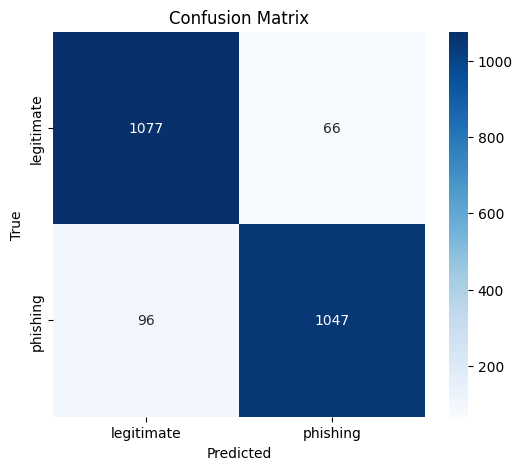

ROC-AUC: 0.9783
PR-AUC : 0.9815
Brier   : 0.0654


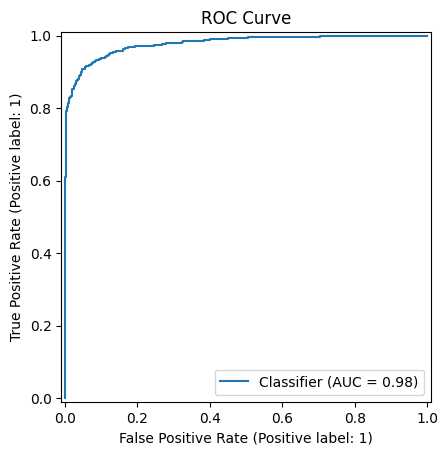

In [12]:

y_pred  = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

print("\nMacro-F1:", f1_score(y_test, y_pred, average='macro'))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")
print(f"PR-AUC : {average_precision_score(y_test, y_proba):.4f}")
print(f"Brier   : {brier_score_loss(y_test, y_proba):.4f}")

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title('ROC Curve')
plt.show()


# Save Model
Saves the trained model and label encoder to use later.






In [13]:

with open('phish_legit_model.pkl', 'wb') as f:
    pickle.dump(pipe, f)
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)
print("Saved model + label encoder.")


Saved model + label encoder.


# Live Predictions (with SOC Workflow)

Allows a security analyst to interactively test URLs, log results, and simulate real SOC triage actions.





In [15]:
ensure_csv_header(LOG_FILE, [
    "timestamp","url","normalized","prediction","confidence",
    "prob_class0","prob_class1","risk","recommended_action",
    "top_positive_contribs","top_negative_contribs"
])
ensure_csv_header(TRIAGE_FILE, [
    "timestamp","url","model_pred","confidence",
    "risk","recommended_action","reviewed_label","analyst_notes"
])

def classify_url_soc(pipeline, label_encoder, threshold=0.5):
    tfidf = pipeline.named_steps['tfidf']
    classes = label_encoder.classes_
    while True:
        url = input("\nEnter a URL (or 'quit'): ").strip()
        if url.lower() == 'quit':
            break
        url_n = normalize_url(url)
        probs = pipeline.predict_proba([url_n])[0]
        final_label = classes[1] if probs[1] >= threshold else classes[0]
        conf = probs[1] if final_label == classes[1] else probs[0]

        risk = risk_from_confidence(final_label, conf)
        action = recommended_action(final_label, risk)
        print(f"\nPredicted: {final_label} (confidence: {conf*100:.2f}%)")
        print(f"Risk: {risk}")
        print(f"Action: {action}")

        pos_contribs, neg_contribs = get_top_contributors(url_n, pipeline, label_encoder)
        print_top_indicators(pos_contribs, neg_contribs, final_label, classes)

        now = datetime.utcnow().isoformat()
        with open(LOG_FILE, "a") as f:
            f.write(",".join([
                now, f"\"{url}\"", f"\"{url_n}\"", final_label,
                f"{conf:.6f}", f"{probs[0]:.6f}", f"{probs[1]:.6f}",
                risk, f"\"{action}\"",
                f"\"{json.dumps(pos_contribs[:10])}\"",
                f"\"{json.dumps(neg_contribs[:10])}\""
            ]) + "\n")
        with open(TRIAGE_FILE, "a") as f:
            f.write(",".join([
                now, f"\"{url}\"", final_label,
                f"{conf:.6f}", risk, f"\"{action}\"", "", ""
            ]) + "\n")
        print(" Logged prediction and triage entry.\n---")

print("\n Model ready. Enter URLs for SOC-style classification:")
classify_url_soc(pipe, le)https://secure-paypal.com.verify-user-session.info/login.php


 Model ready. Enter URLs for SOC-style classification:

Enter a URL (or 'quit'): https://www.nytimes.com/2023/08/31/technology/artificial-intelligence.html

Predicted: legitimate (confidence: 78.88%)
Risk: Medium
Action: Allow, raise for review

=== Top Indicators ===
Toward 'legitimate' (legit):
  - ww  (-0.2041)
  - s://ww  (-0.0816)
  - s://w  (-0.0793)
  - ps://w  (-0.0793)
  - ti  (-0.0659)
  - //www.  (-0.0564)
  - ://www  (-0.0559)
  - //www  (-0.0559)
  - ://ww  (-0.0555)
  - //ww  (-0.0555)
Counter-signals:
  + /a  (0.0324)
  + im  (0.0307)
  + og  (0.0306)
  + log  (0.0298)
  + 202  (0.0288)
  + 02  (0.0288)
  + 31  (0.0275)
  + if  (0.0271)
  + 23  (0.0256)
  + fic  (0.0236)
 Logged prediction and triage entry.
---

Enter a URL (or 'quit'): https://secure-paypal.com.verify-user-session.info/login.php

Predicted: phishing (confidence: 98.03%)
Risk: High
Action: Block, alert user, hunt IOCs

=== Top Indicators ===
🔺 Toward 'phishing' (phishing):
  + php   (0.0865)
  + .php   